In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import svm

configuration = tflscripts.read_configuration()
tflscripts.set_dataset_folder('/home/giotto/transfer-learning-playground/datasets/')

In [2]:
def test_label_with_training_percentage(df, df_labels, label, training_percentage):
    df_positive = df[df_labels.label == label]
    df_labels_positive = df_labels[df_labels.label == label]

    df_labels_negative = df_labels[df_labels.label != label]
    df_negative = df[df_labels.label != label]

    dfs_positive = tflscripts.take_multiple_percentages_of_data(df_positive, df_labels_positive, [training_percentage, 1])
    X_train_positive, df_train_labels_positive = dfs_positive[0]
    X_test_positive, df_test_labels_positive = dfs_positive[1]

    dfs_negative = tflscripts.take_multiple_percentages_of_data(df_negative, df_labels_negative, [0.7, 0.3])
    X_train_negative, df_train_labels_negative = dfs_negative[0]
    X_test_negative, df_test_labels_negative = dfs_negative[1]

    X_train = pd.concat([X_train_positive, X_train_negative])
    X_test = pd.concat([X_test_positive, X_test_negative])
    
    df_train_labels = pd.concat([df_train_labels_positive, df_train_labels_negative])
    df_test_labels = pd.concat([df_test_labels_positive, df_test_labels_negative])

    activity_training_samples = len(X_train_positive)
    non_activity_training_samples = len(X_train_negative)
    activity_testing_samples = len(X_test_positive)
    non_activity_testing_samples = len(X_test_negative)

    print("Number of activity training samples", activity_training_samples)
    print("Number of activity testing samples", activity_testing_samples)

    if activity_training_samples == 0 or activity_testing_samples == 0:
        return None, None, None, None

    y_train = tflscripts.get_y_for_label(df_train_labels, label)
    y_test = tflscripts.get_y_for_label(df_test_labels, label)

    clf = svm.SVC(kernel='linear', decision_function_shape='ovr')

    ppl = Pipeline([
        ('impute', Imputer()),
        ('clf', clf)
    ])

    ppl.fit(X_train, y_train)
    
    positive_X_test = X_test[y_test == label]
    positive_y_test = y_test[y_test == label]

    predicted = ppl.predict(positive_X_test)
    accuracy_positive = accuracy_score(predicted, positive_y_test)
    
    print("Accuracy positive", accuracy_positive)
    
    negative_X_test = X_test[y_test != label]
    negative_y_test = y_test[y_test != label]

    predicted = ppl.predict(negative_X_test)
    accuracy_negative = accuracy_score(predicted, negative_y_test)
    
    print("Accuracy negative", accuracy_negative)
    
    return activity_training_samples, non_activity_training_samples, accuracy_positive, accuracy_negative

In [ ]:
results = []

dataset = 'synergy-final-iter4'
device = '128.237.250.218'

all_activities = [
    "Dishes",
    "Null",
    "Microwave",
    "Coffee",
    "Kettle",
    "Chopping food",
    "Conversation",
    # "Microwave door opened",
    "Microwave door closed",
    "Cupboard door opened",
    "Cupboard door closed",
    "Microwave button press",
    "Knocking",
    # "Phone vibrating",
    "Vacuum cleaning",
    "Blender running",
    "Alarm",
    "Soap dispensed",
    "Microwave done chime"

]
all_activities_i = [configuration['activities'].index(a) for a in all_activities]

activities = [
    "Microwave door closed",
    "Cupboard door opened",
    "Cupboard door closed",
    "Knocking",
    "Soap dispensed",
    "Microwave done chime"

]
activities_i = [configuration['activities'].index(a) for a in activities]

for activity in activities:

    label = configuration['activities'].index(activity)

    df, df_labels = tflscripts.read_and_filter_dataset(
            dataset + '-1s',
            device,
            use_features='.*',
            use_activities=all_activities_i,
            check_all_activities=False,
            scale=True,
            with_feature_selection=False)

    df = df.loc[df.index.isin(df_labels.index)]
    df_labels = df_labels.loc[df_labels.index.isin(df.index)]

    for training_percentage in range(1, 10):
        training_percentage = training_percentage / 10

        print(activity, training_percentage)
        
        all_activity_training_samples, all_non_activity_training_samples, all_accuracy_positive, all_accuracy_negative =\
            [], [], [], []
        
        for _ in range(10):
            activity_training_samples, non_activity_training_samples, accuracy_positive, accuracy_negative = \
                test_label_with_training_percentage(df=df,
                                                    df_labels=df_labels,
                                                    label=label,
                                                    training_percentage=training_percentage)

            if activity_training_samples is None:
                continue
                
            all_activity_training_samples.append(activity_training_samples)
            all_non_activity_training_samples.append(non_activity_training_samples)
            all_accuracy_positive.append(accuracy_positive)
            all_accuracy_negative.append(accuracy_negative)

        activity_training_samples, non_activity_training_samples, accuracy_positive, accuracy_negative = \
            np.mean(all_activity_training_samples), np.mean(all_non_activity_training_samples), \
            np.mean(all_accuracy_positive), np.mean(all_accuracy_negative)

        print()
        print(activity_training_samples, non_activity_training_samples, accuracy_positive, accuracy_negative)
        print()
            
        results.append({
            'activity': activity,
            'training_percentage': training_percentage,
            'accuracy_positive': accuracy_positive,
            'accuracy_negative': accuracy_negative,
            'activity_training_samples': activity_training_samples,
            'non_activity_training_samples': non_activity_training_samples
        })

Microwave door closed 0.1
Number of activity training samples 2
Number of activity testing samples 23
Accuracy positive 0.0
Accuracy negative 1.0
Number of activity training samples 2
Number of activity testing samples 23
Accuracy positive 0.130434782609
Accuracy negative 1.0
Number of activity training samples 2
Number of activity testing samples 23
Accuracy positive 0.0
Accuracy negative 1.0
Number of activity training samples 2
Number of activity testing samples 23
Accuracy positive 0.0434782608696
Accuracy negative 1.0
Number of activity training samples 2
Number of activity testing samples 23
Accuracy positive 0.0434782608696
Accuracy negative 1.0
Number of activity training samples 2
Number of activity testing samples 23
Accuracy positive 0.0
Accuracy negative 1.0
Number of activity training samples 2
Number of activity testing samples 23
Accuracy positive 0.130434782609
Accuracy negative 1.0
Number of activity training samples 2
Number of activity testing samples 23
Accuracy pos

Accuracy positive 0.857142857143
Accuracy negative 1.0
Number of activity training samples 18
Number of activity testing samples 7
Accuracy positive 0.857142857143
Accuracy negative 1.0
Number of activity training samples 18
Number of activity testing samples 7
Accuracy positive 1.0
Accuracy negative 1.0
Number of activity training samples 18
Number of activity testing samples 7
Accuracy positive 0.857142857143
Accuracy negative 1.0
Number of activity training samples 18
Number of activity testing samples 7
Accuracy positive 0.571428571429
Accuracy negative 1.0
Number of activity training samples 18
Number of activity testing samples 7
Accuracy positive 0.857142857143
Accuracy negative 1.0
Number of activity training samples 18
Number of activity testing samples 7
Accuracy positive 0.714285714286
Accuracy negative 1.0
Number of activity training samples 18
Number of activity testing samples 7
Accuracy positive 0.857142857143
Accuracy negative 1.0
Number of activity training samples 18


Accuracy positive 0.235294117647
Accuracy negative 0.999308914997
Number of activity training samples 11
Number of activity testing samples 17
Accuracy positive 0.352941176471
Accuracy negative 1.0
Number of activity training samples 11
Number of activity testing samples 17
Accuracy positive 0.352941176471
Accuracy negative 1.0
Number of activity training samples 11
Number of activity testing samples 17
Accuracy positive 0.411764705882
Accuracy negative 1.0
Number of activity training samples 11
Number of activity testing samples 17
Accuracy positive 0.0588235294118
Accuracy negative 1.0
Number of activity training samples 11
Number of activity testing samples 17
Accuracy positive 0.352941176471
Accuracy negative 0.999308914997

11.0 3377.0 0.311764705882 0.999792674499

Cupboard door opened 0.5
Number of activity training samples 14
Number of activity testing samples 14
Accuracy positive 0.428571428571
Accuracy negative 1.0
Number of activity training samples 14
Number of activity tes

Increasing number of training samples without transfer


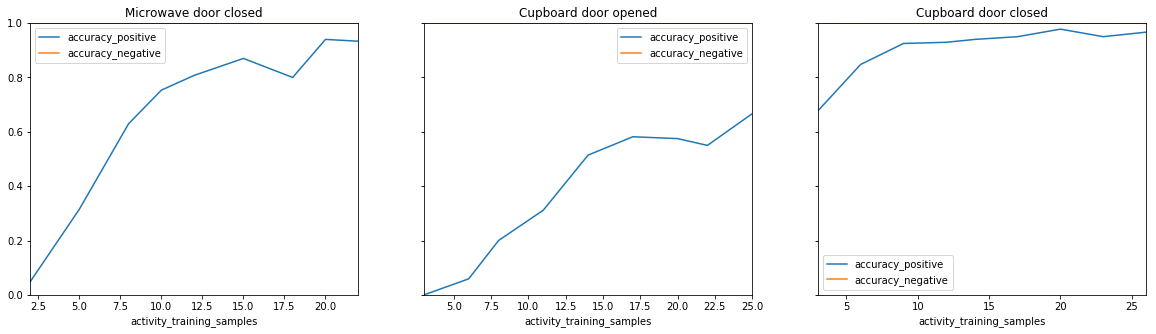

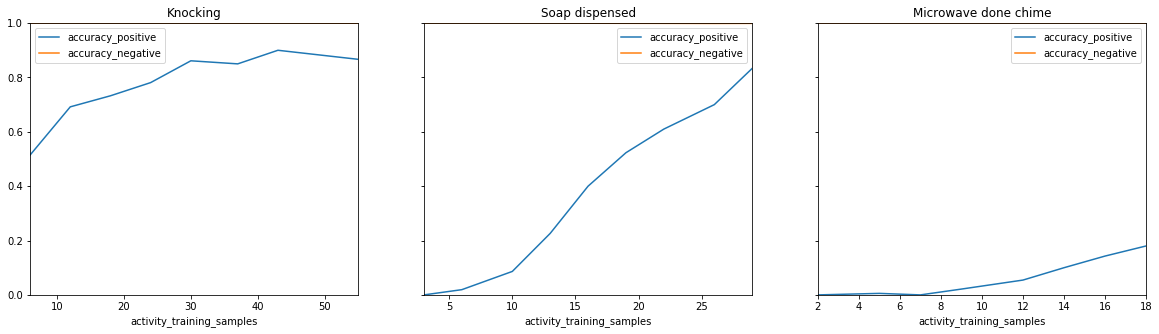

In [6]:
print('Increasing number of training samples without transfer')
plt.rcParams["figure.figsize"] = (20, 5)

df = pd.DataFrame(results)

axes = []
for activity in df.activity.unique():
    if len(axes) == 0:
        f, axes = plt.subplots(1, 3, sharex=False, sharey=True)
        axes = axes.tolist()

        plt.ylim([0,1])
    ax = axes.pop(0)

    activity_df = df.loc[df.activity == activity]
    activity_df = activity_df[['activity_training_samples', 'accuracy_positive', 'accuracy_negative']]
    activity_df = activity_df.set_index('activity_training_samples')
    activity_df.plot(ax=ax)
    matplotlib.pyplot.sca(ax)
    plt.title(activity)

In [5]:
results

[{'accuracy_negative': 0.99993093922651932,
  'accuracy_positive': 0.047826086956521741,
  'activity': 'Microwave door closed',
  'activity_training_samples': 2.0,
  'non_activity_training_samples': 3379.0,
  'training_percentage': 0.1},
 {'accuracy_negative': 1.0,
  'accuracy_positive': 0.31500000000000006,
  'activity': 'Microwave door closed',
  'activity_training_samples': 5.0,
  'non_activity_training_samples': 3379.0,
  'training_percentage': 0.2},
 {'accuracy_negative': 1.0,
  'accuracy_positive': 0.62941176470588245,
  'activity': 'Microwave door closed',
  'activity_training_samples': 8.0,
  'non_activity_training_samples': 3379.0,
  'training_percentage': 0.3},
 {'accuracy_negative': 0.99993093922651932,
  'accuracy_positive': 0.75333333333333319,
  'activity': 'Microwave door closed',
  'activity_training_samples': 10.0,
  'non_activity_training_samples': 3379.0,
  'training_percentage': 0.4},
 {'accuracy_negative': 0.99993093922651932,
  'accuracy_positive': 0.8076923076923